In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from sklearn import metrics
from sklearn import model_selection


In [2]:
# Load the data
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                        "Condition":"condition",
                        "Question":"question_id",
                        "X1":"ss_x",
                        "T1":"ss_t",
                        "X2":"ll_x",
                        "T2":"ll_t",
                        "LaterOptionChosen": "choice"}).drop(['R','G','D'],axis=1)

dataset = cross_valid.generate_sample(itch_dt)

# Define features and label
features = ['ss_x', 'ss_t', 'll_x', 'll_t',
            'abs_diff_x', 'abs_diff_t', 'rel_diff_x','rel_diff_t','growth_x']
label = 'choice'
X = dataset[features]
y = dataset[label]

# Split the data into train sample and test sample 
# Train sample containts 80% of the participants, test sample contains the rest 
groups = dataset['person_id']
train_index,test_index = list(model_selection.GroupShuffleSplit(n_splits=1,train_size=.8,random_state=2023).
                              split(X,y,groups))[0]
train_sample = dataset[dataset.index.isin(train_index)]
test_sample = dataset[dataset.index.isin(test_index)]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=train_sample[features],
                y=train_sample[label],
                groups=train_sample['person_id']))

In [4]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
param_grid = {'n_estimators': [40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, cv=cv, 
                                           scoring="neg_log_loss", refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=train_sample[features], 
                y=train_sample[label], 
                groups=train_sample['person_id'])

# model = xgb.XGBClassifier(objective='binary:logistic',
#                           max_depth=3,
#                           learning_rate=.1,
#                           gamma=.3,
#                           reg_lambda=.7,
#                           subsample=.6,
#                           colsample_bytree=1.0,
#                           eval_metric=['error','logloss'],
#                           early_stopping_rounds=30)
# eval_set = [(X_train, y_train), (X_test, y_test)]
# bst = model.fit(X=X_train,
#                 y=y_train,
#                 eval_set=eval_set,
#                 verbose=True)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([   50,    51,    52, ..., 18085, 18086, 18087])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([  167,   168,   169, ..., 17828, 17829, 17830])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([  192,   193,   194, ..., 18127, 18128, 18129])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([   74,    75,    76, ..., 17729, 17730, 17731])),
                 (array([    0,     1...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [40], 'reg_lambda': [0.7],
                         'subsample': [0.55]},
             refit='neg_log_loss', scoring='neg_log_loss', verbose=3)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40, 'reg_lambda': 0.7, 'subsample': 0.55}
Best score: -0.581191102981182


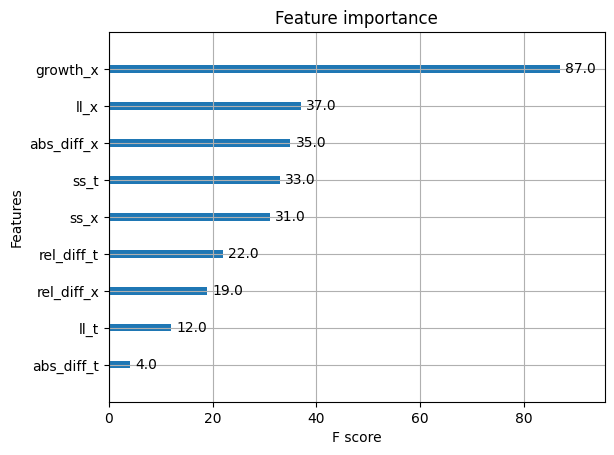

In [5]:
# Save the XGBoost model and check the feature importance
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
bst_model = grid_search.best_estimator_
xgb.plot_importance(bst_model)
with open('my_model.pkl', 'wb') as f:
    pickle.dump(bst_model, f)

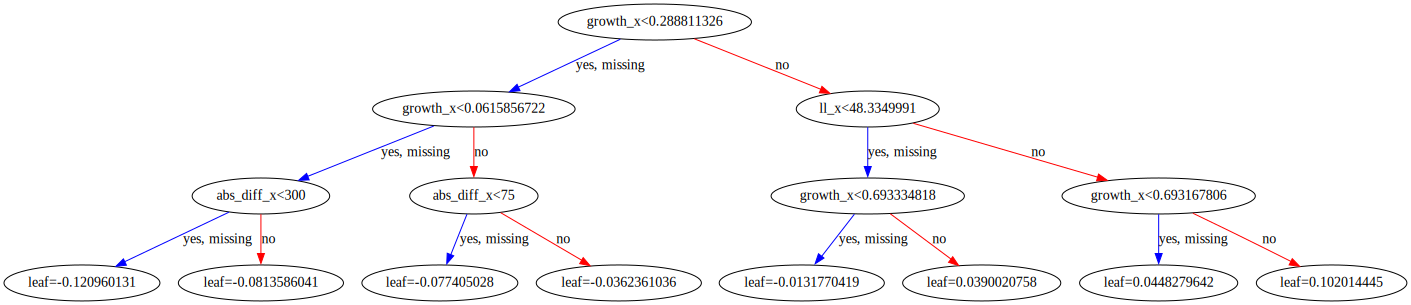

In [6]:
# Plot a decision tree
# Change num_trees from 0 to 39, check different trees
xgb.to_graphviz(bst_model, num_trees=1)

In [86]:
# The out-of-sample performance of XGBoost model
with open('my_model.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

preds = heuristic_model.predict(test_sample[features])
trues = test_sample[label]

pred_binary = (preds > .5)

test_heuristic_dict = {'mse': metrics.mean_squared_error(trues, preds),
                       'mae': metrics.mean_absolute_error(trues, preds),
                       'log_loss': metrics.log_loss(trues, preds),
                       'accuracy': metrics.accuracy_score(trues, pred_binary),
                       'pred_ll':sum(pred_binary)/len(pred_binary)
                       }
test_heuristic_dict

{'mse': 0.29965080750763856,
 'mae': 0.29965080750763856,
 'log_loss': 10.349644658041443,
 'accuracy': 0.7003491924923614,
 'pred_ll': 0.26473155827149714}

In [18]:
# Fit data by distounted utility model and trade-off model
dstyle_list = list(cross_valid.estimation.config_param['discount_func'].keys())
ustyle_list = list(cross_valid.estimation.config_param['utility_func'].keys())
style_list = [{"dstyle":dstyle_list[i],
               "ustyle":ustyle_list[j],
               "method":'logit',
               "intercept":False} 
              for i in range(len(dstyle_list)) for j in range(len(ustyle_list))]

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [1:07:17<00:00, 18.35s/it]


In [64]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result_df['dstyle'] = kf_result_df['style'].apply(lambda x:x['dstyle'])
kf_result_df['ustyle'] = kf_result_df['style'].apply(lambda x:x['ustyle'])
df_cols = kf_result_df.columns.tolist()
df_cols = df_cols[-2:] + df_cols[:-2]
kf_result = kf_result_df.reindex(columns=df_cols).drop('style',axis=1)
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
21,trade,power,"[4.783, 1.275, 39.186, 2.194, 0.159, 0.926]",0.2036,0.4088,0.5947,0.6937,0.2074
13,hbmd,power,"[6.751, 0.149, 0.182]",0.2042,0.4094,0.5978,0.6942,0.2282
3,attention_uni,power,"[1.298, 0.176, 0.326]",0.2088,0.4185,0.6071,0.6840,0.1526
7,expo2,power,"[0.939, 0.786, 0.599, 0.016, 0.014]",0.2094,0.4165,0.6087,0.6845,0.2437
5,expo,power,"[0.992, 0.018, 0.015]",0.2099,0.4205,0.6093,0.6827,0.2405
9,hb,power,"[0.012, 0.027, 0.024]",0.2099,0.4204,0.6097,0.6820,0.2472
15,hce,power,"[0.993, 4.22, 0.01, 0.013]",0.2102,0.4211,0.6098,0.6805,0.2351
11,hb2,power,"[0.003, 3.939, 0.021, 0.019]",0.2105,0.4194,0.6113,0.6824,0.2453
19,quasihb_fc,power,"[0.922, 0.861, 9.834, 0.086, 1.253]",0.2160,0.4362,0.6222,0.6725,0.1628
1,attention,power,"[0.996, 7.781, 0.341, 1.582]",0.2157,0.4358,0.6232,0.6787,0.1715


In [109]:
# Compare models: Out-of-sample performance
test_result = []

for i in range(len(kf_result_df)):

    test_style = kf_result_df['style'][i]
    test_params = kf_result_df['params'][i]

    test_scores = cross_valid.test_model(test_sample=test_sample,style=test_style,params=test_params)
    test_scores['dstyle'] = test_style['dstyle'] 
    test_scores['ustyle'] = test_style['ustyle']
    test_result.append(test_scores)

test_result = pd.DataFrame(test_result)
test_result = test_result.reindex(columns=df_cols).sort_values('log_loss').drop(['style','params'],axis=1)

test_heuristic_dict['dstyle'] = 'gbdt'
test_heuristic_dict['ustyle'] = 'gbdt'

test_result = pd.concat([test_result,pd.DataFrame(test_heuristic_dict,index=[99])])
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.204391,0.407377,0.598332,0.700786,0.213226
9,hb,power,0.208359,0.418450,0.606683,0.690310,0.245089
5,expo,power,0.208574,0.414926,0.607375,0.690310,0.245089
3,attention_uni,power,0.210806,0.419025,0.611358,0.679834,0.149062
15,hce,power,0.211875,0.419064,0.614426,0.674160,0.164775
11,hb2,power,0.212656,0.408161,0.618448,0.674160,0.164775
1,attention,power,0.218415,0.439812,0.628652,0.666521,0.136622
12,hbmd,cara,0.230114,0.457115,0.652744,0.629419,0.082933
2,attention_uni,cara,0.230261,0.457356,0.653074,0.630729,0.076386
14,hce,cara,0.231007,0.458274,0.654510,0.624182,0.041030


In [108]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_sample = cross_valid.generate_sample(rda_sample)
rda_sample['choice'] = heuristic_model.predict(rda_sample[features])

rda_result = []

for i in range(len(kf_result_df)):

    rda_style = kf_result_df['style'][i]
    rda_params = kf_result_df['params'][i]

    rda_scores = cross_valid.test_model(test_sample=rda_sample,style=rda_style,params=rda_params)
    rda_scores['dstyle'] = rda_style['dstyle'] 
    rda_scores['ustyle'] = rda_style['ustyle']
    rda_result.append(rda_scores)

rda_result = pd.DataFrame(rda_result)
rda_result = rda_result.reindex(columns=df_cols).sort_values('log_loss').drop(['style','params'],axis=1)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.116873,0.321717,0.403314,0.919,0.238
11,hb2,power,0.133040,0.331299,0.433513,0.832,0.177
3,attention_uni,power,0.133517,0.343413,0.440199,0.875,0.170
5,expo,power,0.135749,0.343999,0.445010,0.864,0.257
9,hb,power,0.138816,0.350770,0.453273,0.864,0.257
15,hce,power,0.142033,0.351444,0.458364,0.832,0.177
1,attention,power,0.170381,0.393932,0.521401,0.847,0.150
6,expo2,cara,0.199039,0.414823,0.585759,0.713,0.018
10,hb2,cara,0.199729,0.424612,0.588087,0.716,0.045
0,attention,cara,0.199831,0.425581,0.588497,0.733,0.054


In [107]:
# Use the prediction value by magnitude-dependent hyperbolic (hbmd) with power utillity as the label
# Examine which model can explain the hbmd's prediction the best
ss_t = rda_sample['ss_t'].values
ss_x = rda_sample['ss_x'].values
ll_t = rda_sample['ll_t'].values
ll_x = rda_sample['ll_x'].values
kf_init_row = kf_result_df[(kf_result_df['dstyle']=='hbmd') & (kf_result_df['ustyle']=='power')]
init_style = kf_init_row['style'].values[0]
init_params = kf_init_row['params'].values[0]

rda_sample['init_choice'] = cross_valid.choice_rule.choice_prob(ss_x, ss_t, ll_x, ll_t, 
                                                            dstyle = init_style['dstyle'], 
                                                            ustyle = init_style['ustyle'], 
                                                            method = init_style['method'],
                                                            intercept= init_style['intercept'],
                                                            params = init_params[:-1], 
                                                            temper = init_params[-1]) 

rda_sample['choice'] = (rda_sample['init_choice']>.5)

rda_result = []

for i in range(len(kf_result_df)):

    rda_style = kf_result_df['style'][i]
    rda_params = kf_result_df['params'][i]

    rda_scores = cross_valid.test_model(test_sample=rda_sample,style=rda_style,params=rda_params)
    rda_scores['dstyle'] = rda_style['dstyle'] 
    rda_scores['ustyle'] = rda_style['ustyle']
    rda_result.append(rda_scores)

rda_result = pd.DataFrame(rda_result)
rda_result = rda_result.reindex(columns=df_cols).sort_values('log_loss').drop(['style','params'],axis=1)
rda_result.iloc[1:,:]


,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
11,hb2,power,0.119803,0.319621,0.406065,0.897,0.177
5,expo,power,0.127764,0.337258,0.428544,0.890,0.276
15,hce,power,0.130530,0.341162,0.434809,0.897,0.177
9,hb,power,0.132035,0.345079,0.439360,0.890,0.276
3,attention_uni,power,0.133509,0.343434,0.440036,0.887,0.153
1,attention,power,0.168739,0.392427,0.517595,0.879,0.147
6,expo2,cara,0.190935,0.405711,0.568615,0.762,0.014
10,hb2,cara,0.191683,0.416229,0.571144,0.754,0.046
0,attention,cara,0.193003,0.418248,0.574098,0.749,0.053
4,expo,cara,0.193354,0.421716,0.575248,0.753,0.047


In [110]:
# Save the results
kf_result.to_csv("itch_result_kf.csv",index=False)
test_result.to_csv("itch_result_test.csv",index=False)
rda_result.to_csv("itch_result_rda.csv",index=False)